<p style="font-family:Georgia; font-size:16px; text-align:right; background-color:Gainsboro;">Arda Hüseyinoğlu, Spring 2022</p> 
<p style="font-family:Times New Roman; font-size:30px; "><b> BBM446 - Computational Photography Laboratory</b></p>
<p style="font-family:Times New Roman; font-size:30px; "><b> Assignment 2 : HDR Imaging and Tonemapping</b></p>
<br>

In [1]:
import os
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
import warnings
from cp_assgn2 import lRGB2XYZ, XYZ2lRGB, writeHDR, readHDR, read_colorchecker_gm
from tqdm import tqdm
from scipy import interpolate
from skimage import io
from IPython.display import Image

plt.rcParams["figure.figsize"] = (10,6.5)
warnings.filterwarnings('ignore')

<br>
<p style="font-family:Georgia; font-size:23px"><b>1. HDR imaging </b></p>

<p style="font-family:Georgia; font-size:20px"><b>a. Develop RAW images  </b></p>

We run the dcraw with the following flags to to convert the RAW .NEF images into linear 16-bit .TIFF images:

<p > <code> dcraw -v -w -q 3 -o 1 -4 -T exposure1.nef </code> </p>

<p style="font-family:Times New Roman; font-size:18px"><b>Used flags:</b></p>
<ul>
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-w</code> White Balancing: Image is whitebalanced using the camera data.</p></li>
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-q 3</code> Demosaicing: Set interpolation algorithm to Adaptive Homogeneity-Directed (AHD) interpolation, which provides the highest quality. </p></li>
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-o 1</code> Color Space Correction: Set the output color space to sRGB D65.</p></li>  
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-4</code> It generates a linear 16-bit file. </p></li>
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-T</code> It outputs a TIFF image file instead of PPM.</p></li>
  <li><p style="font-family:Times New Roman; font-size:18px"> <code>-v</code> Provides textual information about the development process. </p></li>
</ul>

---

In [2]:
tiff_images = []
for i in range(1,17):
    tiff_images.append(io.imread(f'tiff_images\exposure{i}.tiff'))

In [3]:
for i in range(len(tiff_images)):
    tiff_images[i] = tiff_images[i] / (2**16 - 1)

In [2]:
exposure_factors = [(1/2048) * (2 ** (k-1)) for k in range(1,17)]

<br>
<p style="font-family:Georgia; font-size:20px"><b>b. Linearize rendered images  </b></p>

In [3]:
class Weight:
    def __init__(self, img, exposure_factor, z_min=0.05, z_max=0.95):
        self.img = img
        self.exposure_factor = exposure_factor
        self.z_min = z_min
        self.z_max = z_max
        
    def uniform(self,):
        uniform_weights = np.where((self.z_min <= self.img) & (self.img <= self.z_max), 1, 0)
        return uniform_weights
         
    def tent(self,):
        tent_weights = np.where((self.z_min <= self.img) & (self.img <= self.z_max), np.minimum(self.img, 1 - self.img), 0)
        return tent_weights

    def gaussian(self,):
        gaussian_weights = np.where((self.z_min <= self.img) & (self.img <= self.z_max), np.exp(-4 * (((self.img - 0.5)**2) / (0.5**2))), 0)
        return gaussian_weights
        
    def photon(self,):
        photon_weights = np.where((self.z_min <= self.img) & (self.img <= self.z_max), self.exposure_factor, 0)
        return photon_weights

In [47]:
def gamma_encoding(img):  
    img[img <= 0.0031308] *= 12.92
    img[img > 0.0031308] = (1 + 0.055) * (img[img > 0.0031308]**(1 / 2.4)) - 0.055
    return img

In [5]:
jpg_images = []
for i in range(1,17):
    jpg_images.append(io.imread(f'jpg_images\exposure{i}.jpg'))

In [6]:
jpg_imgs_r = []
jpg_imgs_g = []
jpg_imgs_b = []

for i in range(len(jpg_images)):
    jpg_imgs_r.append(jpg_images[i][:,:,0])
    jpg_imgs_g.append(jpg_images[i][:,:,1])
    jpg_imgs_b.append(jpg_images[i][:,:,2])
    
sample_pixels_r = []
sample_pixels_g = []
sample_pixels_b = []

for i in range(len(jpg_images)):
    sample_pixels_r.append(jpg_imgs_r[i][::200, ::200])
    sample_pixels_g.append(jpg_imgs_g[i][::200, ::200])
    sample_pixels_b.append(jpg_imgs_b[i][::200, ::200])
    
Z_r = np.zeros((len(jpg_images), sample_pixels_r[0].shape[0] * sample_pixels_r[0].shape[1]))
Z_g = np.zeros((len(jpg_images), sample_pixels_r[0].shape[0] * sample_pixels_r[0].shape[1]))
Z_b = np.zeros((len(jpg_images), sample_pixels_r[0].shape[0] * sample_pixels_r[0].shape[1]))

for i in range(len(sample_pixels_r)):
    Z_r[i,:] = sample_pixels_r[i].reshape(1,-1)
    Z_g[i,:] = sample_pixels_g[i].reshape(1,-1)
    Z_b[i,:] = sample_pixels_b[i].reshape(1,-1)

In [7]:
def solve_g(Z, exposure_factors, weight_scheme, l=50):
    
    n = 256
    B = [np.log(i) for i in exposure_factors]
    
    A = np.zeros(shape=(Z.shape[0] * Z.shape[1] + n + 1, n + Z.shape[1]))
    b = np.zeros(shape=(A.shape[0], 1))    
    
    k = 0
    for i in range(Z.shape[1]):
        for j in range(Z.shape[0]):
            z = int(Z[j][i])
            
            weight_o = Weight(np.array([z / 255]), exposure_factors[j])
            wij = 0

            if weight_scheme == 'uniform':
                wij = weight_o.uniform()[0]

            elif weight_scheme == 'tent':
                wij = weight_o.tent()[0]

            elif weight_scheme == 'gaussian':
                wij = weight_o.gaussian()[0]

            elif weight_scheme == 'photon':
                wij = weight_o.photon()[0]

            A[k,z] = wij
            A[k,n+i] = -wij
            b[k] = wij*B[j]
            k += 1
            
    A[k,128] = 1
    k += 1

    for i in range(n-1):
        
        weight_o = Weight(np.array([(i+1) / 255]), exposure_factors[0],0,1) 
        w = 0
        
        if weight_scheme == 'uniform':
            w = weight_o.uniform()[0]
        
        elif weight_scheme == 'tent':
            w = weight_o.tent()[0]
            
        elif weight_scheme == 'gaussian':
            w = weight_o.gaussian()[0]
            
        elif weight_scheme == 'photon':
            w = 1
            
        A[k,i] = l*w
        A[k,i+1] = -2*l*w
        A[k,i+2] = l*w
        k += 1
        
        
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]
    lE = x[n:]
    return g

Text(0.5, 1.0, 'photon')

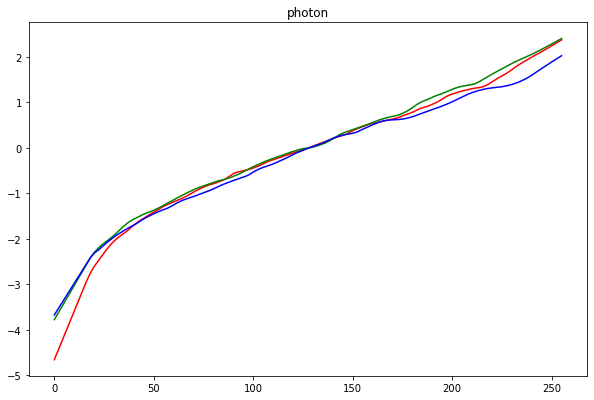

In [8]:
g_r = solve_g(Z_r, exposure_factors, "photon")
g_g = solve_g(Z_g, exposure_factors, "photon")
g_b = solve_g(Z_b, exposure_factors, "photon")

g_r_dict = {i:g_r[i][0] for i in range(g_r.shape[0])}
g_g_dict = {i:g_g[i][0] for i in range(g_g.shape[0])}
g_b_dict = {i:g_b[i][0] for i in range(g_b.shape[0])}

plt.plot(g_r, "r")
plt.plot(g_g, "g")
plt.plot(g_b, "b")
plt.title("photon")

In [9]:
for i in tqdm(range(len(jpg_images))):
    lin_r = np.vectorize(g_r_dict.get)(jpg_imgs_r[i])
    lin_g = np.vectorize(g_g_dict.get)(jpg_imgs_g[i])
    lin_b = np.vectorize(g_b_dict.get)(jpg_imgs_b[i])
    lin_r = np.exp(lin_r)
    lin_g = np.exp(lin_g)
    lin_b = np.exp(lin_b)
    final_lin_img = np.dstack((lin_r, lin_g, lin_b))
    jpg_images[i] = final_lin_img

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:25<00:00,  5.35s/it]


<br>
<p style="font-family:Georgia; font-size:20px"><b>c. Merge exposure stack into HDR image</b></p>

In [10]:
def merge_exposure_stack(img_stack, exposure_factors, merging_mode, weighting_scheme, small_e=0.01):
    img_weights = []
    for i in tqdm(range(len(img_stack))):
        if weighting_scheme == "uniform":
            img_weights.append(Weight(img_stack[i], exposure_factors[i]).uniform())
        elif weighting_scheme == "tent":
            img_weights.append(Weight(img_stack[i], exposure_factors[i]).tent())
        elif weighting_scheme == "gaussian":
            img_weights.append(Weight(img_stack[i], exposure_factors[i]).gaussian())
        elif weighting_scheme == "photon":
            img_weights.append(Weight(img_stack[i], exposure_factors[i]).photon())
        
    numerator = np.zeros(shape=img_stack[0].shape)
    denominator = np.zeros(shape=img_stack[0].shape)
    
    if merging_mode == "linear":
        for i in tqdm(range(len(img_stack))):
            numerator += img_weights[i] * (img_stack[i] / exposure_factors[i])
            denominator += img_weights[i]   
        imm = numerator / (denominator + 0.000000001)
        return imm
            
    elif merging_mode == "logarithmic":
        for i in tqdm(range(len(img_stack))):
            numerator += img_weights[i] * ( np.log(img_stack[i] + small_e) - np.log(exposure_factors[i]) )
            denominator += img_weights[i]  
        imm = numerator / (denominator + 0.000000001)
        imm = np.exp(imm)
        return imm

In [8]:
imm = merge_exposure_stack(tiff_images, exposure_factors, merging_mode="linear", weighting_scheme="uniform")

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:36<00:00,  6.04s/it]


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:07<00:00, 26.69s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


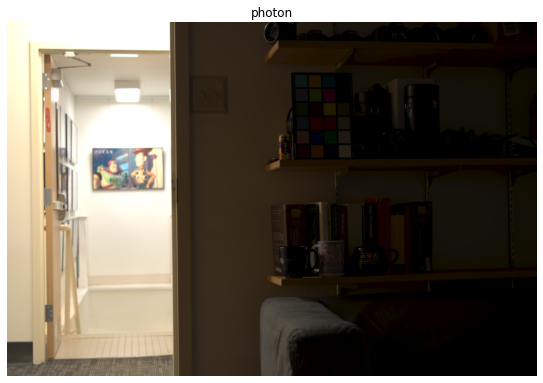

In [10]:
imm = merge_exposure_stack(tiff_images, exposure_factors, merging_mode="linear", weighting_scheme="photon")
plt.imshow(gamma_encoding(imm))
plt.title('photon')
plt.axis('off')
plt.savefig("rapor_resimler/raw_linear_photon.png")
plt.show()

<br>
<p style="font-family:Georgia; font-size:23px"><b>2. Color correction and white balancing</b></p>

In [17]:
%matplotlib qt
plt.imshow(np.clip(imm*5, 0, 1))
plt.show()
x = plt.ginput(24, timeout=300) 
print(x)
%matplotlib inline

[(3340.054346797843, 1441.0719556198223), (3323.837473140803, 1295.120092706461), (3318.431848588456, 1116.7344824790193), (3318.431848588456, 970.782619565658), (3313.02622403611, 808.6138829952565), (3313.02622403611, 641.039521872508), (3491.411834263551, 1451.8832047245155), (3486.006209711205, 1273.4975944970743), (3486.006209711205, 1132.9513561360595), (3486.006209711205, 959.9713704609644), (3469.789336054165, 803.2082584429095), (3458.9780869494707, 657.2563955295482), (3648.174946281606, 1446.477580172169), (3637.363697176913, 1273.4975944970743), (3642.769321729259, 1122.140107031366), (3631.958072624566, 965.376995013311), (3621.1468235198727, 803.2082584429095), (3621.1468235198727, 646.445146424855), (3804.938058299661, 1435.6663310674758), (3799.532433747314, 1273.4975944970743), (3799.532433747314, 1111.3288579266728), (3777.9099355379276, 954.5657459086178), (3783.3155600902737, 808.6138829952565), (3772.5043109855806, 641.039521872508)]


In [10]:
# tiff
x = [(3349.416564185035, 1446.8382434423015), (3338.5620700839227, 1284.0208319256185), (3338.5620700839227, 1126.6306674594916), (3327.7075759828103, 969.2405029933643), (3327.7075759828103, 806.4230914766813), (3322.2803289322546, 649.0329270105544), (3512.233975701718, 1457.6927375434138), (3501.3794816006057, 1289.4480789761747), (3495.95223455005, 1126.6306674594916), (3490.5249874994934, 974.6677500439205), (3468.8159992972696, 800.9958444261251), (3474.2432463478253, 665.3146681622225), (3658.769646066733, 1441.4109963917454), (3653.3423990161773, 1294.8753260267308), (3647.9151519656207, 1132.0579145100478), (3642.487904915065, 974.6677500439205), (3631.6334108139527, 806.4230914766813), (3626.206163763396, 649.0329270105544), (3816.1598105328603, 1452.2654904928577), (3810.7325634823037, 1284.0208319256185), (3805.305316431748, 1126.6306674594916), (3794.4508223306357, 974.6677500439205), (3789.02357528008, 817.2775855777936), (3783.5963282295234, 654.4601740611106)]

In [14]:
# jpg
x = [(3340.054346797843, 1441.0719556198223), (3323.837473140803, 1295.120092706461), (3318.431848588456, 1116.7344824790193), (3318.431848588456, 970.782619565658), (3313.02622403611, 808.6138829952565), (3313.02622403611, 641.039521872508), (3491.411834263551, 1451.8832047245155), (3486.006209711205, 1273.4975944970743), (3486.006209711205, 1132.9513561360595), (3486.006209711205, 959.9713704609644), (3469.789336054165, 803.2082584429095), (3458.9780869494707, 657.2563955295482), (3648.174946281606, 1446.477580172169), (3637.363697176913, 1273.4975944970743), (3642.769321729259, 1122.140107031366), (3631.958072624566, 965.376995013311), (3621.1468235198727, 803.2082584429095), (3621.1468235198727, 646.445146424855), (3804.938058299661, 1435.6663310674758), (3799.532433747314, 1273.4975944970743), (3799.532433747314, 1111.3288579266728), (3777.9099355379276, 954.5657459086178), (3783.3155600902737, 808.6138829952565), (3772.5043109855806, 641.039521872508)]

In [15]:
# take avg. of nxn crops for each patch
def find_patch_avg_rgb_intensity(start_x, start_y, img, n):
    start_x = int(start_x)
    start_y = int(start_y)
    r=0
    g=0
    b=0
    
    for i in range(n):
        for j in range(n):
            rgb_values = img[start_y+i][start_x+j] 
            r += rgb_values[0]
            g += rgb_values[1]
            b += rgb_values[2]
    
    r = r/(n*n)
    g = g/(n*n)
    b = b/(n*n)
    return r,g,b

In [16]:
def color_correction(imm, patches_coordinates_list, patch_size=10):
    img_patches_rgb_values = []
    for i in range(len(patches_coordinates_list)):
        r,g,b = find_patch_avg_rgb_intensity(patches_coordinates_list[i][0], patches_coordinates_list[i][1], imm, patch_size)
        img_patches_rgb_values.append([r,g,b])

    img_patches_rgb_values = np.array(img_patches_rgb_values)
    img_patches_rgb_values = np.insert(img_patches_rgb_values,img_patches_rgb_values.shape[1],1,axis=1)
    
    A = np.zeros(shape=(3*24,12))
    for i in range(img_patches_rgb_values.shape[0]):
        mt = np.zeros(shape=(3,12))
        mt[0,0:4] = img_patches_rgb_values[i]
        mt[1,4:8] = img_patches_rgb_values[i]
        mt[2,8:12] = img_patches_rgb_values[i]
        A[0+i*3 : 3+i*3, 0:12] = mt


    b = []
    gt_patches_rgb_values = read_colorchecker_gm()
    for i in range(gt_patches_rgb_values[0].shape[0]):
        for j in range(gt_patches_rgb_values[0].shape[1]):
            b.append(gt_patches_rgb_values[0][i][j])
            b.append(gt_patches_rgb_values[1][i][j])
            b.append(gt_patches_rgb_values[2][i][j])
    b = np.array(b).reshape(72,1)

    
    affine_transform_x = np.linalg.lstsq(A,b)[0]
    affine_transform_x = affine_transform_x.reshape(3,4)
    
    
    new_im_rgb = imm.reshape(imm.shape[0]*imm.shape[1],3)
    new_im_rgb = np.insert(new_im_rgb,new_im_rgb.shape[1],1,axis=1)
    new_im_rgb = new_im_rgb.T
    resulting_im_rgb = np.dot(affine_transform_x, new_im_rgb)
    resulting_im_rgb = resulting_im_rgb.T
    resulting_im_rgb = resulting_im_rgb.reshape((imm.shape[0],imm.shape[1],3))
    resulting_im_rgb = np.clip(resulting_im_rgb,0,resulting_im_rgb.max())
    
    return resulting_im_rgb

In [17]:
def white_balancing(resulting_im_rgb, patches_coordinates_list):
    patch1_r, patch1_g, patch1_b = find_patch_avg_rgb_intensity(int(patches_coordinates_list[18][0]), int(patches_coordinates_list[18][1]), resulting_im_rgb, 10)
    r_factor = resulting_im_rgb.max() / patch1_r   
    g_factor = resulting_im_rgb.max() / patch1_g   
    b_factor = resulting_im_rgb.max() / patch1_b  
    resulting_im_rgb[:,:,0] *= r_factor
    resulting_im_rgb[:,:,1] *= g_factor
    resulting_im_rgb[:,:,2] *= b_factor
    return resulting_im_rgb

In [37]:
imm = gamma_encoding(imm)

In [38]:
resulting_im_rgb = color_correction(imm, x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


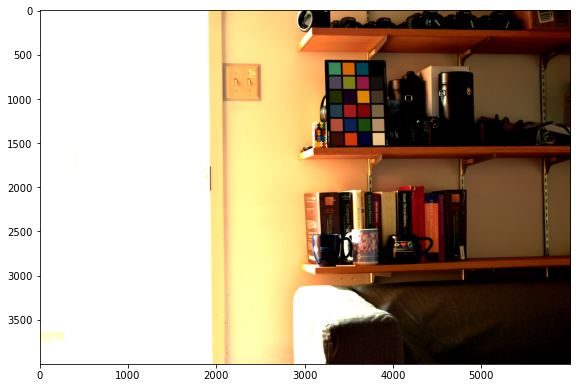

In [39]:
plt.imshow(resulting_im_rgb)

In [40]:
resulting_im_rgb = white_balancing(resulting_im_rgb, x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


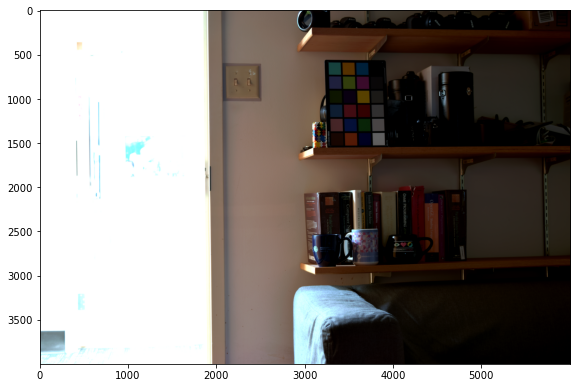

In [49]:
plt.imshow(resulting_im_rgb*0.01)

<br>
<p style="font-family:Georgia; font-size:23px"><b>3. Photographic tonemapping </b></p>

In [31]:
def tonemapping(img, tonemapping_method, K, B, small_e):
    if tonemapping_method == 'RGB':
        I_m_HDR = np.exp(np.sum(np.log(img + small_e)) / (img.shape[0] * img.shape[1] * img.shape[2]))
        I_prime_HDR = (K / I_m_HDR) * img
        I_white = B * np.max(I_prime_HDR)
        imm_tm = (I_prime_HDR * (1 + (I_prime_HDR / I_white**2)) ) / (1 + I_prime_HDR)
        return imm_tm
    
    elif tonemapping_method == 'luminance':
        imm_XYZ = lRGB2XYZ(img)
        
        imm_X = imm_XYZ[:,:,0]
        imm_Y = imm_XYZ[:,:,1]
        imm_Z = imm_XYZ[:,:,2]
        
        imm_x = imm_X / (imm_X + imm_Y + imm_Z)
        imm_y = imm_Y / (imm_X + imm_Y + imm_Z)
        
        I_m_HDR_Y = np.exp(np.sum(np.log(imm_Y + small_e)) / (imm_Y.shape[0] * imm_Y.shape[1] ))
        I_prime_HDR_Y = (K / I_m_HDR_Y) * imm_Y
        I_white_Y = B * np.max(I_prime_HDR_Y)
        imm_tm_Y = (I_prime_HDR_Y * (1 + (I_prime_HDR_Y / I_white_Y**2)) ) / (1 + I_prime_HDR_Y)
        
        Xo = imm_tm_Y * imm_x / imm_y
        Yo = imm_tm_Y
        Zo = imm_tm_Y * ( 1 - imm_x - imm_y ) / imm_y
        imm_tm_XYZ = np.dstack((Xo, Yo, Zo))
        imm_tm_RGB = XYZ2lRGB(imm_tm_XYZ)
        return imm_tm_RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


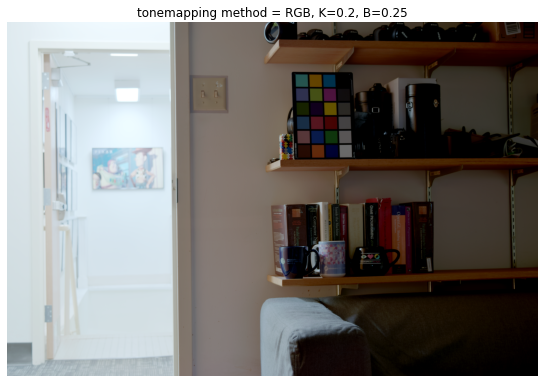

In [88]:
HDR_img_1 = tonemapping(resulting_im_rgb, "RGB", K=0.2, B=0.25, small_e=0.001)
plt.imshow(HDR_img_1)
plt.axis('off')
plt.title("tonemapping method = RGB, K=0.2, B=0.25")
plt.savefig("rapor_resimler/final_RGB.png")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


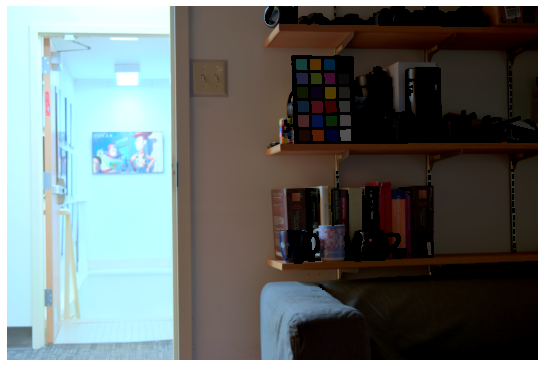

In [95]:
HDR_img_2 = tonemapping(resulting_im_rgb, "luminance", K=0.2, B=0.20, small_e=0.001)
plt.imshow(HDR_img_2)
plt.axis('off')
plt.title("tonemapping method = RGB, K=0.2, B=0.2")
plt.savefig("rapor_resimler/final_luminance.png")
plt.show()